In [1]:
import numpy as np
import h5py

import MDAnalysis as mda
from MDAnalysis import analysis

import importlib
import XS_calc
from XS_calc import *

import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib inline


In [2]:
import scipy
scipy.__version__

'1.7.3'

In [3]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

#### Import experimental files for 1l2y

In [4]:
filename = "data/20220404_trpcage_reconstructed_saxs.h5"
h5 = h5py.File(filename)
print(h5.keys())

<KeysViewHDF5 ['q_SAD', 's_SAD', 's_SAD_err', 's_int', 's_int_err', 's_unf', 's_unf_err']>


In [5]:
# Set measurement q to experimental q
mea = Measurement(q = np.squeeze(h5['q_SAD'][:]))
print(np.shape(mea.q))

(136,)


In [6]:
# Create Experiment class objects for each species
F_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][0,:]), S_err = np.squeeze(h5['s_SAD_err'][0,:]))
U_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][1,:]), S_err = np.squeeze(h5['s_SAD_err'][1,:]))
I_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_int'][:]), S_err = np.squeeze(h5['s_int_err'][:]))
U_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_unf'][:]), S_err = np.squeeze(h5['s_unf_err'][:]))

<IPython.core.display.Javascript object>


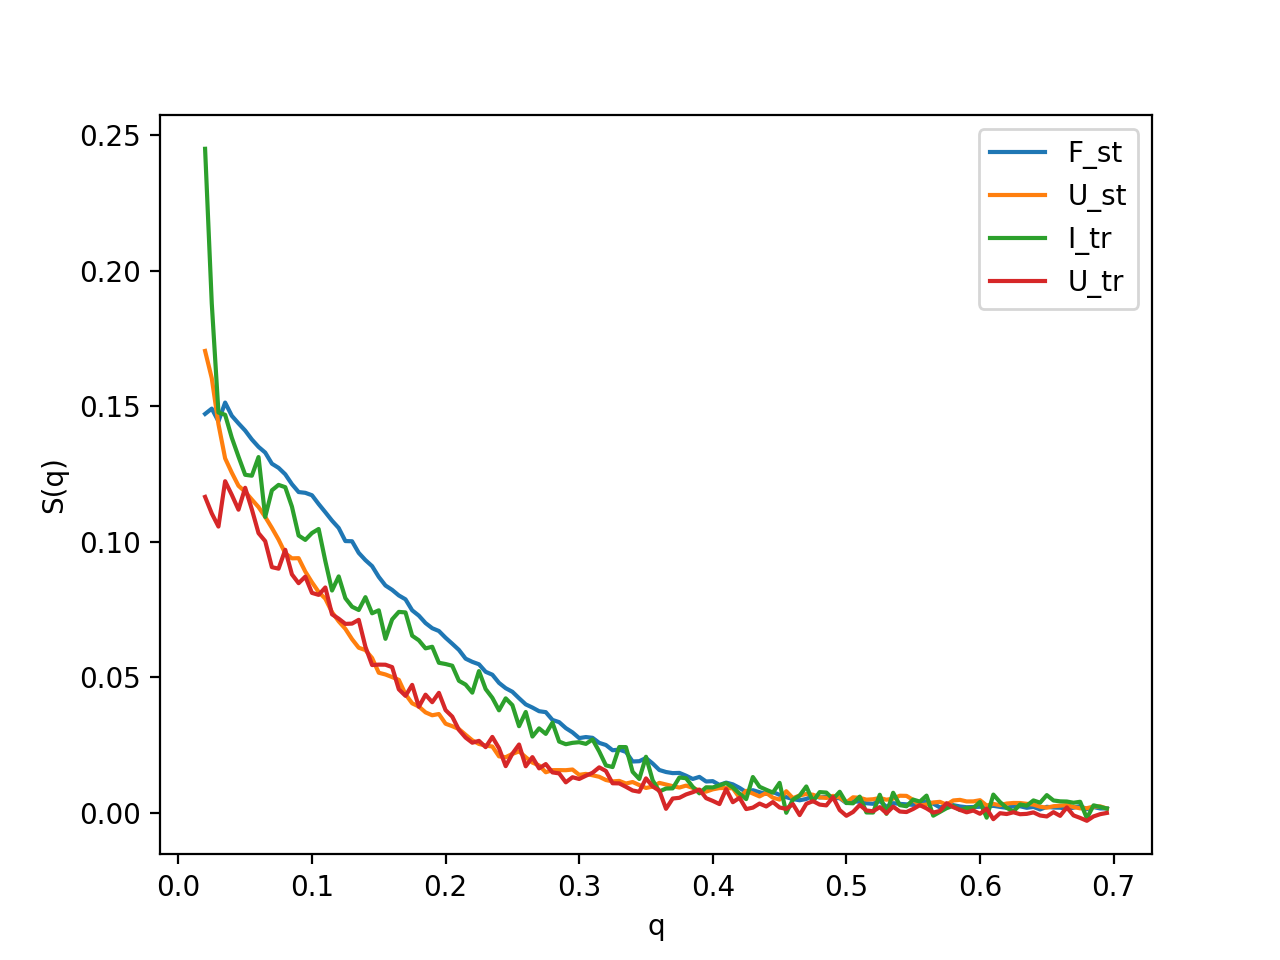

In [7]:
plt.figure()
plt.plot(F_st.q, F_st.S_exp, label="F_st")
plt.plot(U_st.q, U_st.S_exp, label="U_st")
plt.plot(I_tr.q, I_tr.S_exp, label="I_tr")
plt.plot(U_tr.q, U_tr.S_exp, label="U_tr")
plt.xlabel('q')
plt.ylabel('S(q)')
plt.legend()
plt.show()

#### Import the MD trajectory and perform XS calculation on trajectory

In [8]:
# This would be a typical use case

U = mda.Universe("data/1l2y_wb_ions.psf", "data/1l2y_unfold_300K.dcd")

# full trajectory
# traj = traj_slice(U, selection='protein')

# first 100 frames
# traj = Trajectory_slice(U, selection="protein", frame_max = 10)

# This doesn't work yet... OverflowError: Python int too large to convert to C long
# every 50 frames
traj = Trajectory_slice(U, selection="protein", frame_min=0, frame_step=10, ffdir='form_factors/')

print(np.shape(traj.Frames))

env = Environment()

# XS = traj_calc(traj, env, mea)
# print(np.shape(XS))
# Do something with XS. E.g. fitting etc.


There are 10005.0 total frames
Taking the first in every 10.0 frames
(1001,)


#### Compute for every c1 / c2 permutaion the XS_calc of every structure

In [204]:
aa = traj_calc(traj, env, mea, method='frame_XS_calc_fast')

Done in 32.9359 seconds


In [205]:
aa.shape

(1001, 136)

In [9]:
from itertools import product

In [10]:
c1_grid = np.arange(0.98, 1.051, 0.01)
c2_grid = np.arange(0.0, 4.01, 0.2)
c1c2_product = list(product(c1_grid, c2_grid))
print(len(c1c2_product))

168


In [209]:
XS_pool = {}
for c1c2 in c1c2_product:
    print(f'Condition: {c1c2}', end=' ')
    c1, c2 = c1c2
    env = Environment(c1=c1, c2=c2)
    XS_pool[c1c2] = traj_calc(traj, env, mea, method='frame_XS_calc_fast')

Condition: (0.98, 0.0) Done in 31.4899 seconds
Condition: (0.98, 0.2) Done in 31.0220 seconds
Condition: (0.98, 0.4) Done in 37.0400 seconds
Condition: (0.98, 0.6000000000000001) Done in 34.9262 seconds
Condition: (0.98, 0.8) Done in 33.8705 seconds
Condition: (0.98, 1.0) Done in 31.8721 seconds
Condition: (0.98, 1.2000000000000002) Done in 33.3595 seconds
Condition: (0.98, 1.4000000000000001) Done in 35.0061 seconds
Condition: (0.98, 1.6) Done in 30.9243 seconds
Condition: (0.98, 1.8) Done in 32.2130 seconds
Condition: (0.98, 2.0) Done in 33.8280 seconds
Condition: (0.98, 2.2) Done in 30.6797 seconds
Condition: (0.98, 2.4000000000000004) Done in 32.3202 seconds
Condition: (0.98, 2.6) Done in 32.0598 seconds
Condition: (0.98, 2.8000000000000003) Done in 32.7862 seconds
Condition: (0.98, 3.0) Done in 31.2239 seconds
Condition: (0.98, 3.2) Done in 32.6256 seconds
Condition: (0.98, 3.4000000000000004) Done in 33.8718 seconds
Condition: (0.98, 3.6) Done in 31.4625 seconds
Condition: (0.98,

Condition: (1.05, 2.2) Done in 34.6669 seconds
Condition: (1.05, 2.4000000000000004) Done in 33.7341 seconds
Condition: (1.05, 2.6) Done in 33.1470 seconds
Condition: (1.05, 2.8000000000000003) Done in 32.1869 seconds
Condition: (1.05, 3.0) Done in 35.1907 seconds
Condition: (1.05, 3.2) Done in 31.8184 seconds
Condition: (1.05, 3.4000000000000004) Done in 31.1770 seconds
Condition: (1.05, 3.6) Done in 30.8538 seconds
Condition: (1.05, 3.8000000000000003) Done in 32.5316 seconds
Condition: (1.05, 4.0) Done in 29.3184 seconds


In [11]:
import pickle
# pickle.dump(XS_pool, open('data/1l2y_unfold_300K_XS.pkl', 'wb'))
XS_pool = pickle.load(open('data/1l2y_unfold_300K_XS.pkl','rb'))

In [12]:
for key in XS_pool.keys():
    print(XS_pool[key].shape)

(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(1001, 136)
(100

In [38]:
# Get genetic algorithm working
import multiprocessing as mp

def fit_chromosome(chromosome):
    chromosome.fit()
    return chromosome

class Chromosome:
    
    def __init__(self, gene_pool, target_data, target_err, pool_options=None, n_genes=50, gene_indices=None):
        self.gene_pool = gene_pool
        self.target_data = target_data
        self.target_err = target_err
        self.pool_options = pool_options
        self.n_genes = n_genes
        self.gene_indices = gene_indices
        self.fitness = np.inf
        self.pool_option = None
        self.is_survivor = False
        self.expression = None
        self.res = None
        
    def fit(self):
        
        if self.pool_options is None:
            if not self.is_survivor:
                gene_avg = np.mean(self.gene_pool[self.gene_indices], axis=0)
                chi2_fun = lambda x: np.sqrt(np.mean( (((gene_avg * x[0] + x[1]) - self.exp_data) / self.exp_err)**2 ))
                res_this = minimize(chi2_fun, (self.exp_data[0] / gene_avg[0] ,0), method='L-BFGS-B')
                self.fitness = res.fun
        else:
            if not self.is_survivor:
                sub_chi2 = np.inf
                sub_option = None
                sub_res = None
                for pool_option in self.pool_options:
                    gene_avg = np.mean(self.gene_pool[pool_option][self.gene_indices], axis=0)
                    chi2_fun = lambda x: np.sqrt(np.mean( (((gene_avg * x[0] + x[1]) - self.target_data) / self.target_err)**2 ))
                    res_this = minimize(chi2_fun, (self.target_data[0] / gene_avg[0] ,0), method='L-BFGS-B')
                    chi2_this = res_this.fun

                    if chi2_this < sub_chi2:
                        sub_chi2 = chi2_this
                        sub_option = pool_option
                        sub_res = res_this
                self.fitness = sub_chi2
                self.pool_option = sub_option
                self.res = sub_res
                
        
    def assign(self, pool_option=None, fitness=None, is_survivor=None, res=None):
        if pool_option is not None:
            self.pool_option = pool_option
        if fitness is not None:
            self.fitness = fitness
        if is_survivor is not None:
            self.is_survivor = is_survivor
        if res is not None:
            self.res = res
        
    def individual_gene_data(self):
        if self.pool_option is not None:
            gene_data = self.gene_pool[self.pool_option][self.gene_indices]
        else:
            gene_data = self.gene_pool[self.gene_indices]
        return (np.mean(gene_data * self.res.x[0] + self.res.x[1], axis=0), gene_data * self.res.x[0] + self.res.x[1])

    
class GeneticAlgorithm:
    
    def __init__(self, gene_pool, target_data, target_err=None, 
                 n_chromosomes=150, n_survive=50, n_mutate=50, n_cross=50, n_genes=50):
        # Gene pool is the "data", an nD numpy array, or a dict of such
        # If a dict, then different keys of the dict are considered pool options
        # Every pool option must have the same number of gene pools
        self.gene_pool = gene_pool
        self.pool_options = None
        self.pool_length = None
        self.n_chromosomes = n_chromosomes
        self.n_survive = n_survive
        self.n_mutate = n_mutate
        self.n_cross = n_cross
        self.n_genes = n_genes
        if self.n_chromosomes != self.n_survive + self.n_mutate + self.n_cross:
            self.n_chromosomes = self.n_survive + self.n_mutate + self.n_cross
        
        
        if type(gene_pool) == dict:
            self.pool_options = gene_pool.keys()
            # Check that within all options the gene pools are the same length
            pool_length_each_options = np.array([len(self.gene_pool[key]) for key in self.pool_options])
            if not np.all(pool_length_each_options == pool_length_each_options[0]):
                print("Warning: Not all pool options have the same number of genes")
            self.pool_length = pool_length_each_options[0]
            # Register options, makesure within all options the gene pools are the same length
        elif type(gene_pool) == list or type(gene_pool) == np.ndarray:
            self.pool_length = len(gene_pool)
        
        
        # Process data
        self.target_data = target_data
        if target_err is None:
            self.target_err = np.ones_like(self.target_data)
        else:
            self.target_err = target_err
        
        # Create chromosomes
        self.chromosome_pool = []
        for _ in range(self.n_chromosomes):
            self.chromosome_pool.append(Chromosome(self.gene_pool,
                                                   self.target_data,
                                                   self.target_err,
                                                   pool_options=self.pool_options,
                                                   n_genes=self.n_genes,
                                                   gene_indices=np.random.choice(range(self.pool_length), n_genes)))

        self.evolution_round = 0
        self.evolution_checkpoint = 0


            
    def report(self):
        print(f'This genetic algorithm: {len(self.chromosome_pool)} chromosomes, each with {self.n_genes} genes')
        print(f'For evolution, keep {self.n_survive}, mutate {self.n_mutate}, and cross {self.n_cross} chromosomes')
        
        
    def evolve(self, n=1, use_mp=False):
        # Calculate fit of every chromosome
        for round_counter in range(n):
            print(f'Round {round_counter + self.evolution_checkpoint}, processing chromosomes ...')
            fitness = np.zeros(self.n_chromosomes)
            if use_mp:
                raise NotImplementedError('Currently not working')
                self.fit_all_mp()
            else:
                self.fit_all()
            for idx, chromosome in enumerate(self.chromosome_pool):
                fitness[idx] = chromosome.fitness
            # Sort fitness
            fitness_rank = np.argsort(fitness)
            survivors = [self.chromosome_pool[x] for x in fitness_rank[:self.n_survive]]
            for survivor in survivors:
                survivor.assign(is_survivor=True)
            mutated = []
            crossed = []
            for chromosome in survivors:
                mutated.append(self.mutate(chromosome))
                crossed.append(self.cross(chromosome))
            self.chromosome_pool = survivors + mutated + crossed
            
            print(f'\nBest fit is: {np.min(fitness)} at {survivors[0].pool_option}')
            self.evolution_round += 1
        self.evolution_checkpoint = self.evolution_round
        
    def fit_all(self):
        for idx, chromosome in enumerate(self.chromosome_pool):
            if idx % 10 == 9:
                print(f'{idx+1}', end=' ')
            chromosome.fit()
            
    def fit_all_mp(self):
        print('using multiprocessing', end=' ')
        pool = mp.Pool()
        res = pool.map(fit_chromosome, self.chromosome_pool)
        pool.close()
        pool.join()
        self.chromosome_pool = res
        
    
    def mutate(self, chromosome):
        n_old_genes = np.ceil(chromosome.n_genes * 0.8).astype(int)
        n_new_genes = chromosome.n_genes - n_old_genes
        old_genes = np.random.choice(chromosome.gene_indices, n_old_genes, replace=False)
        new_genes = np.random.choice(self.pool_length, n_new_genes)
        new_chromosome = Chromosome(self.gene_pool,
                                    self.target_data,
                                    self.target_err,
                                    pool_options=self.pool_options,
                                    n_genes=self.n_genes,
                                    gene_indices=np.concatenate((old_genes, new_genes)))
        
        return new_chromosome
    
    def cross(self, chromosome):
        other_chromosome = np.random.choice(self.chromosome_pool, 1)[0]
        combined_genes = np.concatenate((chromosome.gene_indices, other_chromosome.gene_indices))
        new_genes = np.random.choice(combined_genes, self.n_genes)
        new_chromosome = Chromosome(self.gene_pool,
                                    self.target_data,
                                    self.target_err,
                                    pool_options=self.pool_options,
                                    n_genes=self.n_genes,
                                    gene_indices=new_genes)
        
        return new_chromosome

    def get_best_fit(self):
        if self.pool_options is not None:
            best_data = self.chromosome_pool[0].individual_gene_data()
        else:
            best_data = self.chromosome_pool[0].individual_gene_data()
        return best_data

In [39]:
ga = GeneticAlgorithm(XS_pool, F_st.S_exp, F_st.S_err, 
                      n_genes=100, n_cross=5, n_mutate=5, n_survive=5)

In [40]:
ga.report()

This genetic algorithm: 15 chromosomes, each with 100 genes
For evolution, keep 5, mutate 5, and cross 5 chromosomes


In [42]:
ga.evolve(n=3, use_mp=False)

Round 0, processing chromosomes ...
10 
Best fit is: 0.4802285750049268 at (1.05, 1.0)
Round 1, processing chromosomes ...
10 
Best fit is: 0.4762586543566143 at (1.05, 1.0)
Round 2, processing chromosomes ...
10 
Best fit is: 0.4762586543566143 at (1.05, 1.0)


<IPython.core.display.Javascript object>


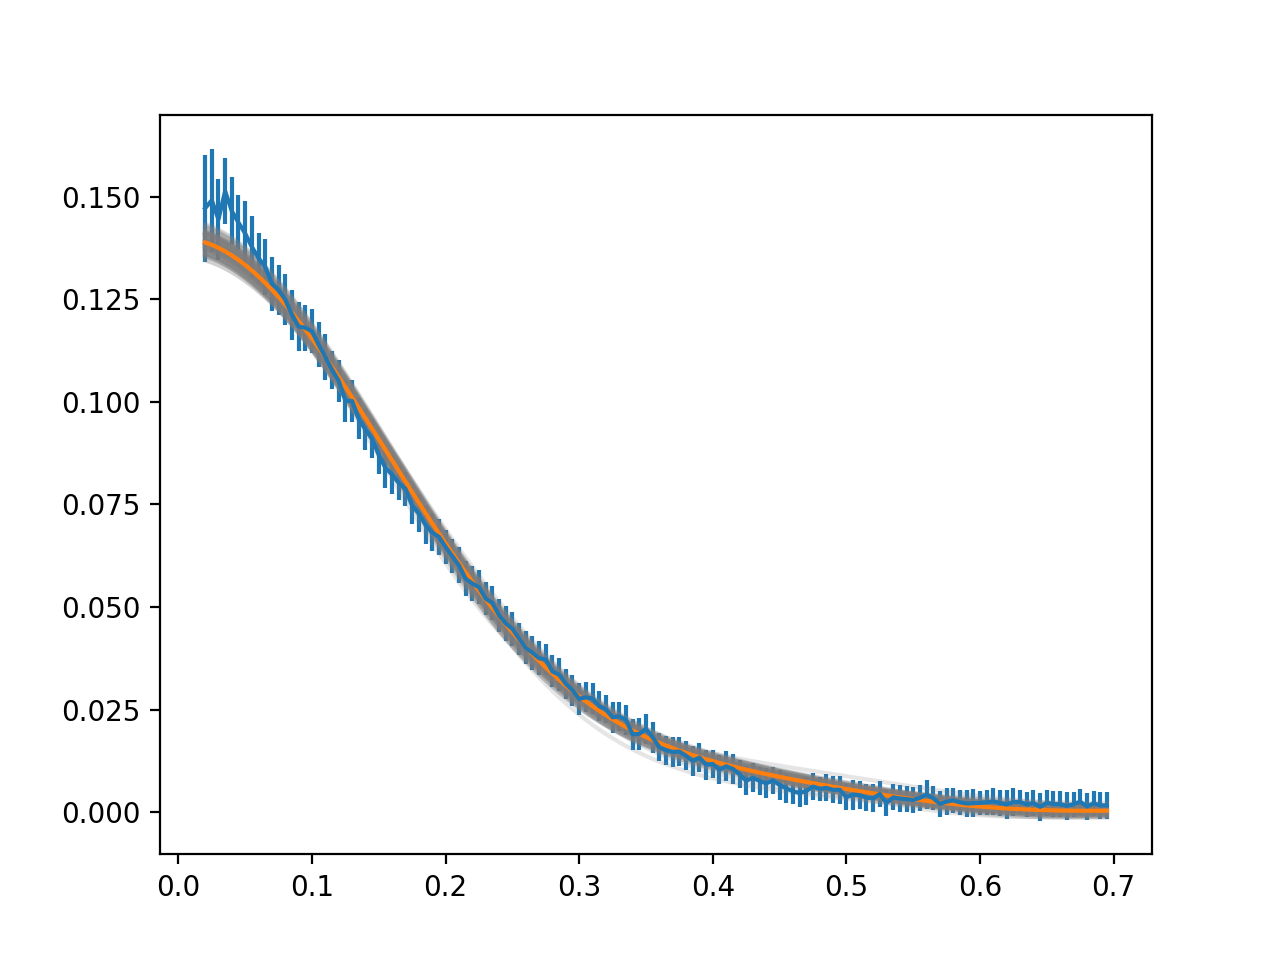

[ 6.70814905e-06 -1.06956109e-02]


In [43]:
plt.figure(dpi=100)
bf = ga.get_best_fit()
plt.errorbar(F_st.q, F_st.S_exp, F_st.S_err)
plt.plot(mea.q, bf[1].T, color='tab:gray', alpha=0.2)
plt.plot(mea.q, bf[0])

print(ga.chromosome_pool[0].res.x)

In [218]:
ga.evolve(n=5)

Round 8, processing chromosomes ...
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 
Best fit is: 0.4348878809699564 at (1.05, 1.0)
Round 9, processing chromosomes ...
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 
Best fit is: 0.4348878809699564 at (1.05, 1.0)
Round 10, processing chromosomes ...
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 
Best fit is: 0.4348878809699564 at (1.05, 1.0)
Round 11, processing chromosomes ...
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 
Best fit is: 0.4346979302396 at (1.05, 1.0)
Round 12, processing chromosomes ...
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 
Best fit is: 0.4297234413196375 at (1.05, 1.0)
